In [76]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
# Print out the version of PlantCV being used by the Jupyter kernel
import torch
import torch.nn.functional as F
import cv2

from dpt.dpt import DPTModel
from util.metric import eval_rel_depth, align_by_lstsq, eval_rel_depth_segmentwise, align_to_range
from util.utils import filer_sample_noise, get_samples
torch.cuda.set_device(0) 
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def show_anns(segwise_metric, segmentation, valid_mask, ax):
    metric_list = []
    img = np.ones((segmentation.shape[0], segmentation.shape[1], 4))
    img[:, :, 3] = 0

    for s in segwise_metric:
        smask = segmentation == s['segment_id']
        smask = smask & valid_mask
        if s['segment_id'] == 0 or np.sum(smask) < 500:
            continue
        y, x = np.where(smask)
        metric = s['seg_pearson'] 
        metric_list.append(metric)
        ax.set_title(f'Segment-wise Metric {np.mean(metric_list):.3f}')

        if len(y) > 0 and len(x) > 0:
            ax.text(np.mean(x), np.mean(y), f'{metric:.2f}', color='black', ha='center', va='center', fontsize=8, bbox=dict(facecolor='black', alpha=0.2))

        contours, _ = cv2.findContours(smask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        cv2.drawContours(img, contours, -1, (0, 0, 0, 0.7), thickness=2) 
    ax.imshow(img)


## Image and GT Depth Load

In [78]:
img_path = '/home/yuezhuo/PlantMDE/release/example/rgb/spinach_example.png'
sample = get_samples(img_path)
ori_image = sample['image']
depth = sample['depth'] / 256
mask = sample['mask']
rgb_mask = depth > 0
segmentation = sample['segmentation']
image = ori_image.copy()
image[rgb_mask == 0] = [70,70,70]

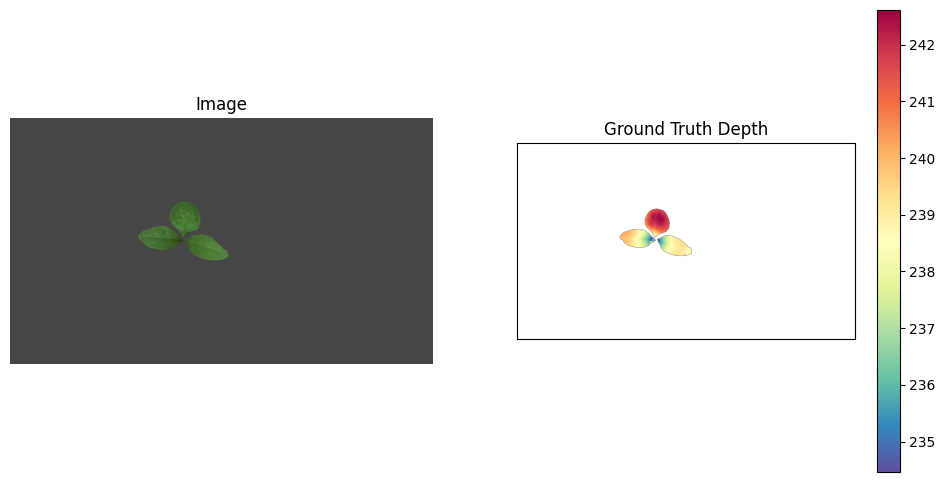

In [79]:
mask = filer_sample_noise(depth, mask, 0.016,0.9996)
depth[mask == 0 ] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Image')

im = axes[1].imshow(depth, cmap='Spectral_r')
# axes[1].axis('off')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Ground Truth Depth')
fig.colorbar(im, ax=axes[1])
plt.show()


## Depth Estimation by PlantMDE

/tmp/ipykernel_2564765/516364403.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(plantmde, map_location='cpu')['model']


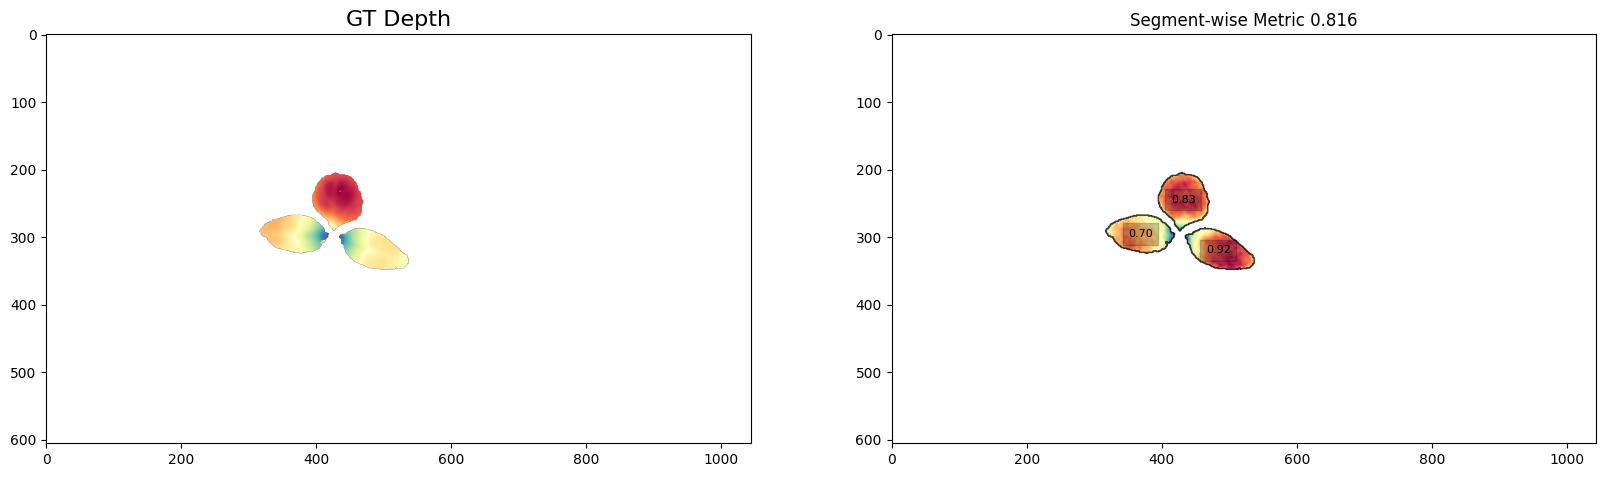

In [80]:

plantmde = '/home/yuezhuo/PlantMDE/checkpoints/plantmde.pth'


state_dict = torch.load(plantmde, map_location='cpu')['model']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v
model = DPTModel(**{**model_configs[encoder]})
model.load_state_dict(new_state_dict)
model = model.to(DEVICE).eval()

pred_disp = model(model.image2tensor(image)[0])
pred_disp = F.interpolate(pred_disp[:, None], (depth.shape[0], depth.shape[1]), mode="bilinear", align_corners=True)[0,0].cpu().detach().numpy()

valid_mask_filter = filer_sample_noise(pred_disp, mask, 0.05, 1)
valid_mask_filter_base = valid_mask_filter
depth_mask = np.copy(depth)
depth_mask[valid_mask_filter == 0] = np.nan
pred_disp[valid_mask_filter == 0] = np.nan


segwise_metric = eval_rel_depth_segmentwise(pred_disp, depth_mask, valid_mask_filter, segmentation, [0.00,1], retrun_segmentwise_metrics=True, )

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(depth_mask,cmap='Spectral_r')
ax[0].set_title('GT Depth', fontsize=16)
ax[1].imshow(pred_disp,cmap='Spectral_r')
show_anns(segwise_metric, segmentation,valid_mask_filter, ax[1])



### Convert depth to point cloud

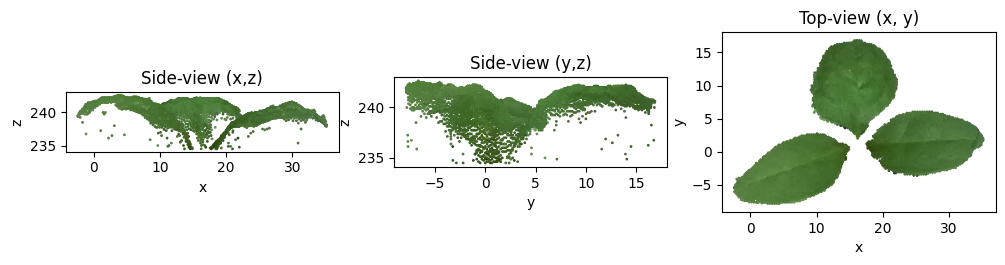

In [81]:
import vis
masked_img = np.copy(ori_image)
masked_img[valid_mask_filter == 0] = [0,0,0]
nor_depth = align_to_range(pred_disp, depth_mask, valid_mask_filter)
nor_depth[valid_mask_filter == 0] = np.nan
points, colors = vis.depth_to_cloud_point(masked_img, nor_depth, 1387.8287, 1387.8287)
point_color = np.hstack((points, colors))

# A quick way to review the point cloud
vis.review_pcd(points, colors, 2)
# 3D point cloud can be better observed with open3d interface

## Depth Anything

/tmp/ipykernel_2564765/4222868393.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_state_dict = torch.load(vits, map_location='cpu')


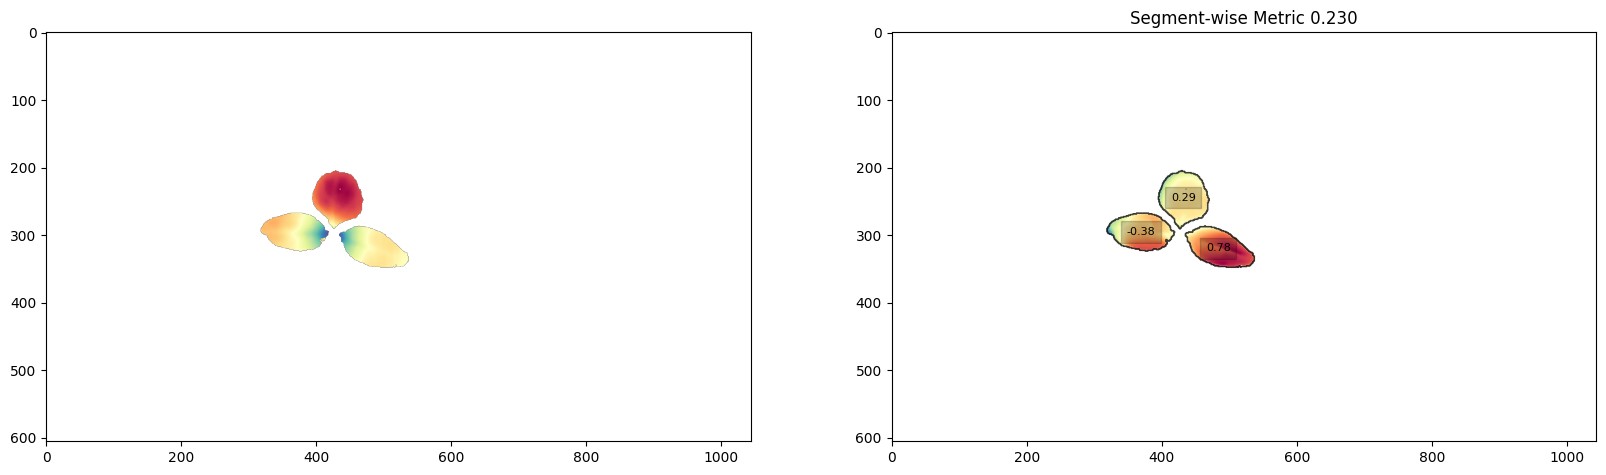

In [82]:
vits = '/home/yuezhuo/PlantMDE/checkpoints/depth_anything_v2_vits.pth'
new_state_dict = torch.load(vits, map_location='cpu')
model2 = DPTModel(**{**model_configs[encoder]})
model2.load_state_dict(new_state_dict)
model2 = model2.to(DEVICE).eval()
pred_disp = model2(model2.image2tensor(ori_image)[0])
pred_disp = F.interpolate(pred_disp[:, None], (depth.shape[0], depth.shape[1]), mode="bilinear", align_corners=True)[0,0].cpu().detach().numpy()

valid_mask_filter = filer_sample_noise(pred_disp, mask, 0.01, 1)
valid_mask_filter = valid_mask_filter & valid_mask_filter_base
depth_mask = np.copy(depth)
depth_mask[valid_mask_filter == 0] = np.nan
pred_disp[valid_mask_filter == 0] = np.nan


segwise_metric = eval_rel_depth_segmentwise(pred_disp, depth_mask, valid_mask_filter, segmentation, [0.01,1], retrun_segmentwise_metrics=True, )

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(depth_mask,cmap='Spectral_r')
ax[1].imshow(pred_disp,cmap='Spectral_r')
show_anns(segwise_metric, segmentation,valid_mask_filter, ax[1])


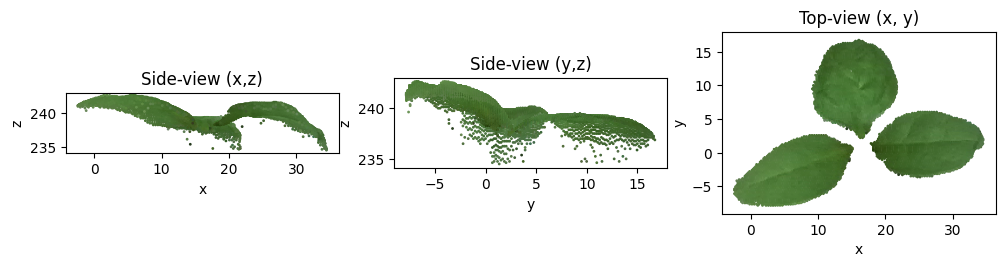

In [83]:
import vis
masked_img = np.copy(ori_image)
masked_img[valid_mask_filter == 0] = [0,0,0]
nor_depth = align_to_range(pred_disp, depth_mask, valid_mask_filter)
nor_depth[valid_mask_filter == 0] = np.nan
points, colors = vis.depth_to_cloud_point(masked_img, nor_depth, 1387.8287, 1387.8287)
point_color = np.hstack((points, colors))
vis.review_pcd(points, colors, 2)
